# Polynomial regression

In [1]:
# Uncomment to upgrade packages
#!pip3 install pandas --upgrade --user --quiet
#!pip3 install numpy --upgrade --user --quiet 
#!pip3 install scipy --upgrade --user --quiet
#!pip3 install statsmodels --upgrade --user --quiet 
#!pip3 install scikit-learn --upgrade --user --quiet
%load_ext autoreload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import style
import seaborn as sns

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('precision', 3)


Bad key backend.qt4 in file C:\Users\Inanna\.matplotlib\matplotlibrc, line 45 ('backend.qt4 : PyQt4')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
# extra imports
from numpy.random import uniform, normal
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [ ]:
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

Fix the random number genrator so the experiment is reproducible

In [ ]:
np.random.seed(7)

We will approximate the function $cos(3\pi x)$ using polynomials

In [ ]:
def feval(x):
    return np.cos(3*np.pi*x)

def fgen(N, sigma):
    x = np.sort(uniform(a, b, N))
    t = feval(x) + normal(loc=0, scale=sigma, size=N)  
    return x,t

## Generate training dataset..

We start generating a sample of 30 examples generating the data assuming that has gaussian noise $N(0,0.25^2)$

In [7]:
N = 30
a = 0
b = 1
sigma = 0.25

In [8]:
x,t = fgen(N, sigma)
sample = pd.DataFrame({'input':x,'target':t})

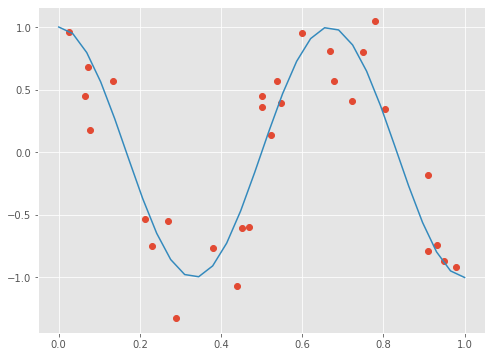

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(sample.input, sample.target, 'o')
ax.plot(np.linspace(0, 1,num=30), 
        feval(np.linspace(0, 1,num=30)));

## Generate validation set

We generate also a vaidation set to evaluate the error with unseen data

In [10]:
N_valid = 1000
x_valid, t_valid = fgen(N_valid, sigma)
valid_sample =  pd.DataFrame({'input':x_valid,'target':t_valid})

## Fit polynomials for a range of degrees, no regularization

We sample the range (0,1) and plot the predictions

In [11]:
p = 1
q = 26

coef = []
model = []
norm_mse_train = []
norm_mse_valid = []

for i in range(p,q):
    cmodel = LinearRegression()
    cmodel.fit(np.vander(sample.input,i+1, increasing=True), sample.target)
    coef.append(cmodel.coef_)
    predictions = cmodel.predict(np.vander(sample.input,
                                              i+1, increasing=True))  
   
    
    norm_mse_train.append(mean_squared_error(predictions, sample.target))
    
    pred_val = cmodel.predict(np.vander(valid_sample.input,
                                              i+1, increasing=True))  
    norm_mse_valid.append(mean_squared_error(pred_val, valid_sample.target))
    model.append(cmodel)
0;

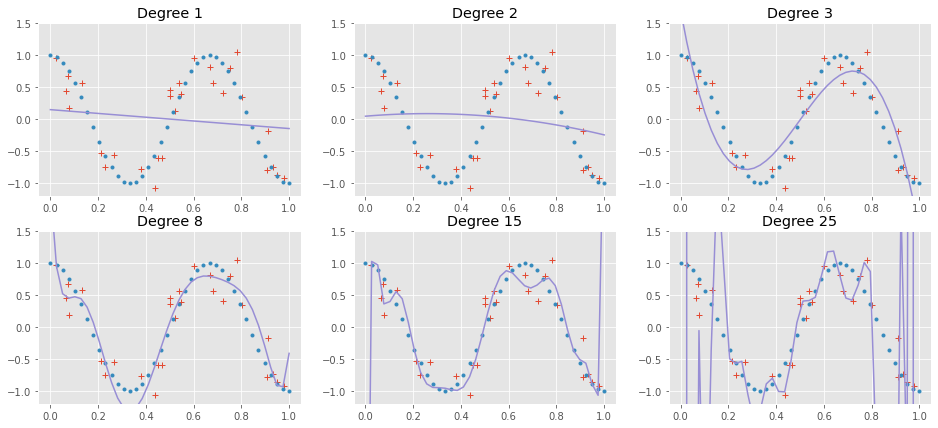

In [12]:
fig = plt.figure(figsize=(16,7))

for f, i in enumerate([1,2,3,8,15,25]):
    ax = fig.add_subplot(2,3,f+1)
    ax.plot(sample.input, sample.target, '+')
    ax.plot(np.linspace(0, 1,num=40), 
            feval(np.linspace(0, 1,num=40)), '.');
    ax.plot(np.linspace(0, 1,num=40), 
            model[i-1].predict(np.vander(np.linspace(0, 1,num=40),
                                              i+1, 
                                              increasing=True)));
    plt.ylim(-1.2,1.5)
    plt.title('Degree %d'%i)
0;

### Plot training/validation error curves

This is the difference among the train and validation data

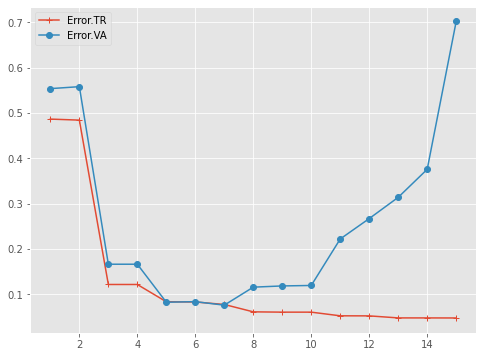

In [13]:
pol =15
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,pol+1), norm_mse_train[0:pol], '-+', label='Error.TR')
plt.plot(range(1,pol+1), norm_mse_valid[0:pol], '-o', label='Error.VA')
plt.legend();

### Plot coefficients' average magnitudes as a fn. of degree

These are the means of the abssolute value of the coefficients fitted for each polynomial in logarithmic scale

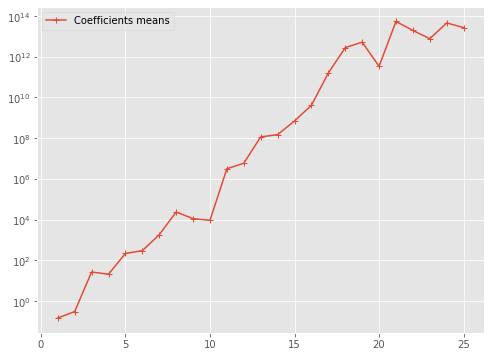

In [14]:
pol=25
means = []
for m in model:
    means.append(np.mean(np.abs(m.coef_)))
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,pol+1), means[0:pol], '-+', label='Coefficients means')
plt.yscale('log')
plt.legend();

## Fit polynomials, with regularization

Now we repeat the same but using regularization; we first find the best regularization parameter using cross validation

In [15]:
p = 1
q = 26

coef = []
model = []
norm_mse_train = []
norm_mse_valid = []


rlambda = np.linspace(0.001, 0.5, num=50)
for i in range(p,q):
    cmodel = RidgeCV(alphas=rlambda, scoring=make_scorer(mean_squared_error, greater_is_better=False))
    cmodel.fit(np.vander(sample.input,i+1, increasing=True), sample.target)
    coef.append(cmodel.coef_)

    predictions = cmodel.predict(np.vander(sample.input, i+1, increasing=True))
    norm_mse_train.append(mean_squared_error(predictions, sample.target))
    
    pred_val = cmodel.predict(np.vander(valid_sample.input, i+1, increasing=True))  
    norm_mse_valid.append(mean_squared_error(pred_val, valid_sample.target))
    
    model.append(cmodel)
0;

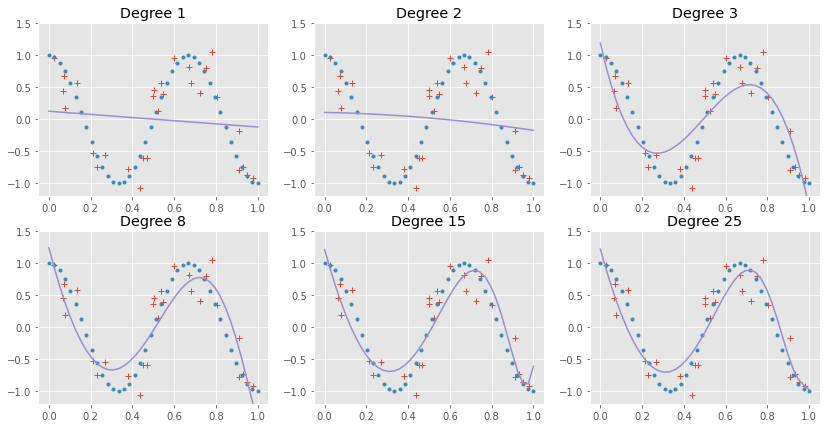

In [16]:
fig = plt.figure(figsize=(14,7))

for f, i in enumerate([1,2,3,8,15,25]):
    ax = fig.add_subplot(2,3,f+1)
    ax.plot(sample.input, sample.target, '+')
    ax.plot(np.linspace(0, 1,num=40), 
            feval(np.linspace(0, 1,num=40)), '.');
    ax.plot(np.linspace(0, 1,num=40), 
            model[i-1].predict(np.vander(np.linspace(0, 1,num=40),
                                              i+1, 
                                              increasing=True)));
    plt.ylim(-1.2,1.5)
    plt.title('Degree %d'%i)
0;

### Plot training/validation error curves, as fn. of degree

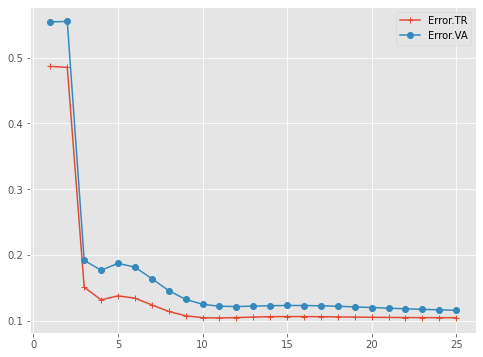

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
pol =25
plt.plot(range(1,pol+1), norm_mse_train[0:pol], '-+', label='Error.TR')
plt.plot(range(1,pol+1), norm_mse_valid[0:pol], '-o', label='Error.VA')
plt.legend();

Now the coefficients are smaller due to the regularization, now we do not need logarithmic scale to represent them

### Plot coefficients' average magnitudes

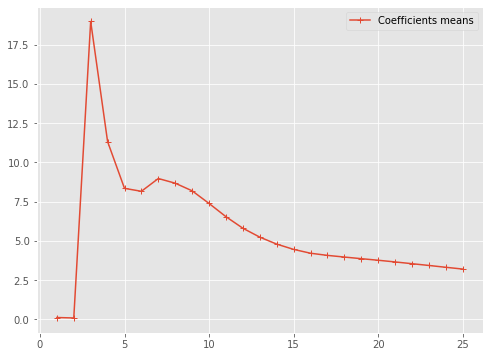

In [18]:
means = []
for m in model:
    means.append(np.mean(np.abs(m.coef_)))
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,pol+1), means[0:pol], '-+', label='Coefficients means')
plt.legend();

## Visualization of coefficients for regularized ridge and lasso

### Visualization of coefficients of *ridge* linear regression as a function of $\lambda$

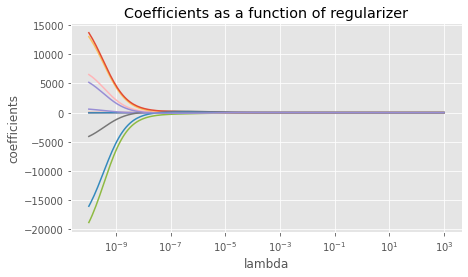

In [19]:
lambdas = np.logspace(-10, 3, 200)
coefs = []

for l in lambdas:
    tmp_model = Ridge(alpha=l, fit_intercept=False, normalize=True)
    tmp_model.fit(np.vander(sample.input, 10, increasing=True), sample.target)
    coefs.append(tmp_model.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlabel('lambda')
ax.set_ylabel('coefficients')
ax.set_title('Coefficients as a function of regularizer');
plt.axis('tight')
0;

### Visualization of coefficients of *lasso* linear regression as a function of $\lambda$

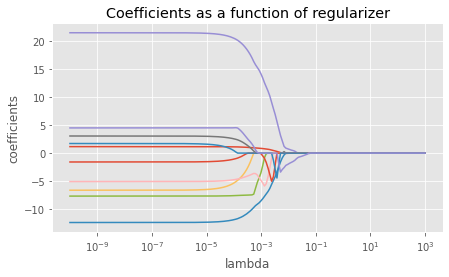

In [20]:
lambdas = np.logspace(-10, 3, 200)
coefs = []

for l in lambdas:
    tmp_model = Lasso(alpha=l, fit_intercept=False, normalize=True)
    tmp_model.fit(np.vander(sample.input, 10, increasing=True), sample.target)
    coefs.append(tmp_model.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlabel('lambda')
ax.set_ylabel('coefficients')
ax.set_title('Coefficients as a function of regularizer');
plt.axis('tight')
0;

## Comparison of coefficients for ordinary least squares, ridge and lasso for a fixed degree

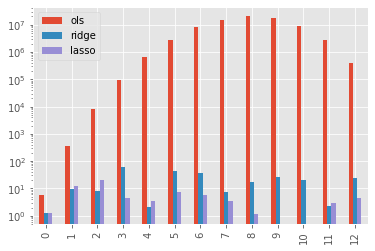

In [31]:
degrees = 13

lambdas = np.logspace(-10, 3, 200)
X = np.vander(sample.input, degrees, increasing=True)
names = range(1, degrees+1)
y = sample.target

# ordinary least squares, ridge and lasso
ols = LinearRegression(fit_intercept=False, normalize=True).fit(X, y)
ridge = RidgeCV(alphas=lambdas, fit_intercept=False, normalize=True).fit(X, y)
lasso = LassoCV(alphas=lambdas, fit_intercept=False, normalize=True).fit(X, y)

coef = pd.DataFrame({'ols': np.absolute(ols.coef_.flatten()),
                    'ridge': np.absolute(ridge.coef_.flatten()),
                    'lasso': np.absolute(lasso.coef_.flatten())})
coef.plot.bar(logy=True)

0;

In [32]:
coef

,ols,ridge,lasso
0,5.830e+00,1.248,1.220
1,3.500e+02,9.595,12.695
2,8.270e+03,7.778,20.464
3,9.733e+04,59.195,4.377
4,6.622e+05,2.012,3.604
5,2.843e+06,42.781,7.409
6,8.064e+06,35.951,5.967
7,1.543e+07,7.583,3.536
8,1.994e+07,17.391,1.141
9,1.709e+07,27.364,0.000


## Bias/Variance trade-off, with ordinary least squares


In this last section, we are going to showcase the effect of bias/variance on the overall MSE error. To this end we are going to generate several datasets with additive independent Gaussian noise, from the same distribution. We are going to:

1. visualize bias, variance for small and large-degree polynomials
2. compute bias, variance for small and large-degree polynomials
3. compute mse for small and large-degree polynomials, and compare it to the known bound mse = bias^2 + variance + sigma

### Visualize bias and variance for small degree polynomial

In [33]:
def do_visualization_of_degree(degree, x0):
    fig = plt.figure(figsize=(14,7))

    repeats = 10
    N = 10
    sigma = 0.25  # additive noise N(0,sigma^2)

    preds = [None] * repeats # will store predictions for locations in x0 for each sample
    
    for i in range(repeats):
        x, y = fgen(N, sigma)  # generate new sample of size N
        sample = pd.DataFrame({'input':x, 'target':y})
        
        # fit model
        model = LinearRegression()
        model.fit(np.vander(sample.input,degree+1, increasing=True), sample.target)
        
        # record predictions
        preds[i] = model.predict(np.vander(x0, degree+1, increasing=True))
        
        ax = fig.add_subplot(2, 5, i+1)
        ax.plot(sample.input, sample.target, '+')
        ax.plot(np.linspace(0, 1,num=40), feval(np.linspace(0, 1,num=40)), '.');
        ax.plot(np.linspace(0, 1,num=40), model.predict(np.vander(np.linspace(0, 1,num=40), degree+1, increasing=True)));
        plt.ylim(-1.2,1.5)
        plt.title(f'Repeat {i+1}')  
        
    return pd.DataFrame(preds, columns=x0)

def bias_variance(deg, df, x0):
    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(np.linspace(0, 1, num=40), feval(np.linspace(0, 1,num=40)), 'b.');
    df2 = df.melt(var_name='x0', value_name='pred')
#    ax = sns.violinplot(x="groups", y="vals", data=df2)
    ax.plot(x0, df.mean(), 'rx')
    ax.plot(df2.x0, df2.pred, 'r.')

    ymin = np.amin([-1.2, df2.pred.min()])
    ymax = np.amax([1.5, df2.pred.max()])
    
    print(f'min:{ymin}, max:{ymax}')
    plt.ylim(ymin, ymax)
    plt.title(f'Bias/Variance for degree {deg}')    

#### Now print predictions of 10 models trained

min:-1.340703157709006, max:1.5


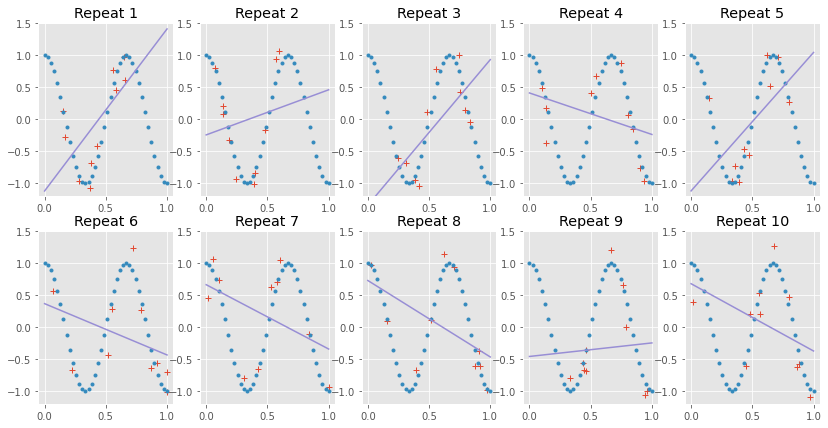

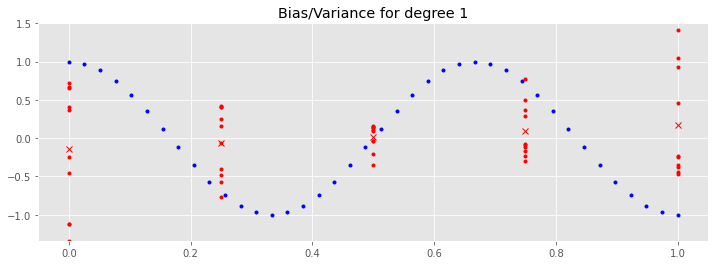

In [34]:
x0 = np.linspace(0,1,5)    # locations where to store predictions

df = do_visualization_of_degree(1, x0)
bias_variance(1, df, x0)

### Now repeat with higher-degree polynomial

min:-11.414321012252381, max:6.213534232616673


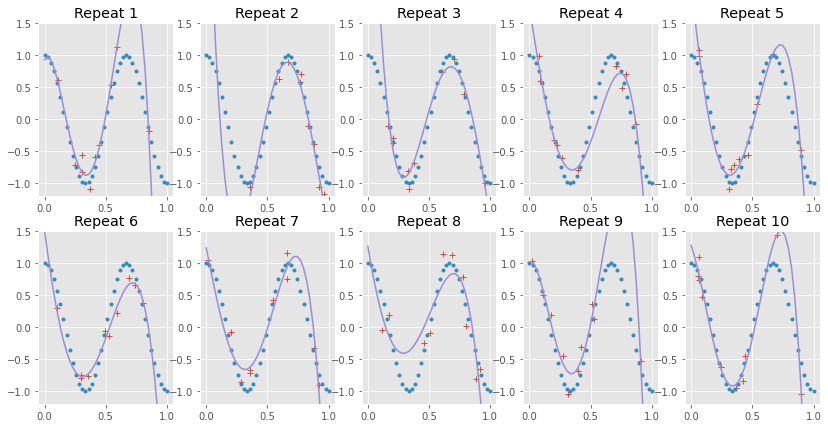

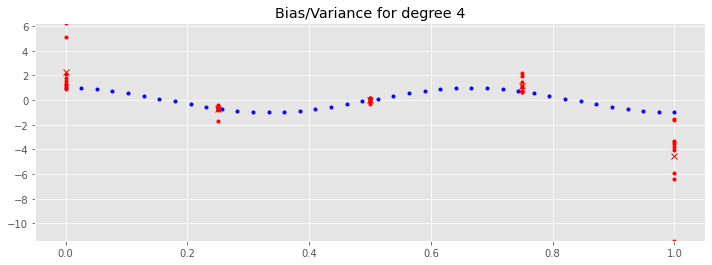

In [35]:
df = do_visualization_of_degree(4, x0)
bias_variance(4, df, x0)

## Finally plot bias^2, variance, mse as a fn. of degree

In [87]:
sigma = 2  # additive noise N(0,sigma^2)
N = 500
x0 = np.linspace(0,1,10)    # locations where to store predictions

def compute_predictions_for_degree(degree, x0, repeats=20):

    preds = [None] * repeats # will store predictions for locations in x0 for each sample
    
    for i in range(repeats):
        x, y = fgen(N, sigma)  # generate new sample of size N
        sample = pd.DataFrame({'input':x, 'target':y})
        
        # fit model
        model = LinearRegression()
        model.fit(np.vander(sample.input,degree+1, increasing=True), sample.target)
        
        # record predictions
        preds[i] = model.predict(np.vander(x0, degree+1, increasing=True))
        
    return pd.DataFrame(preds, columns=x0)

<AxesSubplot:xlabel='degree'>

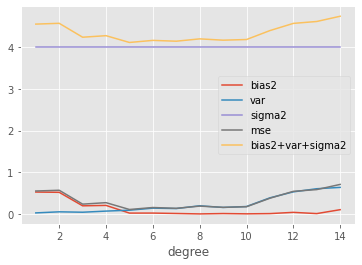

In [88]:
# for all degrees, compute stats
all_deg = range(1, 15)
data = [None] * len(all_deg)
for i, deg in enumerate(all_deg):
    df = compute_predictions_for_degree(deg, x0)

    bias = df.mean(axis=0) - feval(x0) # bias at each location in x0
    
    bias2 = np.mean(bias**2)      # mean squared bias (over points in x0)
    var = df.var(axis=0).mean()   # mean var (over points in x0)

    res = df.to_numpy() - feval(x0)
    res2 = res**2
    mse = res2.mean(axis=0).mean() # mean mse (over points in x0)
    
    data[i] = [deg, bias2, var, sigma**2, mse, bias2+var+sigma**2]

df = pd.DataFrame(data, columns=['degree', 'bias2', 'var', 'sigma2', 'mse', 'bias2+var+sigma2'])
df.plot(x='degree')

In [82]:
df

,degree,bias2,var,sigma2,mse,bias2+var+sigma2
0,1,0.504,0.098,4,0.593,4.602
1,2,0.519,0.150,4,0.654,4.669
2,3,0.099,0.225,4,0.301,4.324
3,4,0.111,0.213,4,0.303,4.324
4,5,0.029,0.262,4,0.265,4.292
5,6,0.071,0.376,4,0.409,4.447
6,7,0.030,0.459,4,0.443,4.489
7,8,0.020,0.522,4,0.490,4.542
8,9,0.031,0.437,4,0.425,4.468
9,10,0.087,1.093,4,1.071,5.180
